<a href="https://colab.research.google.com/github/xDEVELYNNx/hand_gesture_recognition/blob/main/hand_gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#load data
data_test=pd.read_csv("https://raw.githubusercontent.com/VinitaSilaparasetty/hand-gesture-recognition/main/sign_mnist_test.csv")
data_train=pd.read_csv("/content/drive/MyDrive/sign_mnist_train.csv")

In [4]:
data_test.head()


label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      6     149     149     150  ...       106       112       120       107
1      5     126     128     131  ...       184       184       182       180
2     10      85      88      92  ...       226       225       224       222
3      0     203     205     207  ...       230       240       253       255
4      3     188     191     193  ...        49        46        46        53

[5 rows x 785 columns]

In [5]:
def show_img(img,df):
  label=data_test['label'][img]
  pixels=data_test.iloc[img,1:]
  pixels=np.array(pixels,dtype='uint8')
  pixels=pixels.reshape((28,28))

  plt.title('label is {label}'.format(label=label))
  plt.imshow(pixels,cmap='gray')
  plt.show()


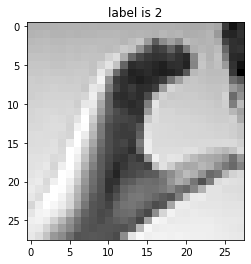

In [6]:
show_img(20,data_test)

In [7]:
#extract labels

y_train=data_train['label']
y_test=data_test['label']
del data_train['label']
del data_test['label']


In [8]:
#label binarize

label_binarizer=LabelBinarizer()

y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = data_train.values
x_test = data_test.values


In [9]:
#normalization

x_train = x_train/255
x_test = x_test/255


In [10]:
#reshape

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)


In [11]:
#data augmentation 

data_generator = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization= False,
    zca_whitening =False,
    rotation_range= 10,
    zoom_range =0.1,
    width_shift_range = 0.1,
    height_shift_range =0.1,
    horizontal_flip = False,
    vertical_flip = False,
    )

In [12]:
data_generator.fit(x_train)

In [13]:
#build model 

model=Sequential()
model.add(Conv2D(75,(3,3), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2,padding='same'))
model.add(Conv2D(50,(3,3), strides=1,padding='same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2,padding='same'))
model.add(Conv2D(25,(3,3), strides=1,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=24,activation='softmax'))


In [14]:
#compile model 

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
#set learning rate

learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5,min_lr=0.00001)


In [16]:
#train model 

model.fit(data_generator.flow(x_train,y_train,batch_size=128),epochs=20,validation_data=(x_test,y_test),callbacks=[learning_rate_reduction])


Epoch 1/20
215/215 [==============================] - 44s 65ms/step - loss: 1.8278 - accuracy: 0.4645 - val_loss: 4.3734 - val_accuracy: 0.0542
Epoch 2/20
215/215 [==============================] - 13s 60ms/step - loss: 0.2978 - accuracy: 0.9021 - val_loss: 1.4007 - val_accuracy: 0.5867
Epoch 3/20
215/215 [==============================] - 13s 60ms/step - loss: 0.1298 - accuracy: 0.9591 - val_loss: 0.1307 - val_accuracy: 0.9589
Epoch 4/20
215/215 [==============================] - 13s 60ms/step - loss: 0.0738 - accuracy: 0.9780 - val_loss: 0.1948 - val_accuracy: 0.9349
Epoch 5/20
215/215 [==============================] - 13s 61ms/step - loss: 0.0548 - accuracy: 0.9822 - val_loss: 0.0389 - val_accuracy: 0.9905
Epoch 6/20
215/215 [==============================] - 13s 61ms/step - loss: 0.0398 - accuracy: 0.9880 - val_loss: 0.3569 - val_accuracy: 0.8795
Epoch 7/20
215/215 [==============================] - 13s 60ms/step - loss: 0.0366 - accuracy: 0.9882 - val_loss: 0.0742 - val_accuracy:

In [17]:
#check final accuracy 

model.evaluate(x_test,y_test)


225/225 [==============================] - 1s 5ms/step - loss: 7.5504e-04 - accuracy: 1.0000


[0.0007550385198555887, 1.0]

In [18]:
predictions= model.predict_classes(x_test)
for i in range(len(predictions)):
  if( predictions[i]>=9 or predictions[i]>=25):
    predictions[i]+=1
predictions[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([ 6,  5, 10,  0,  3, 21, 10, 14,  3,  7])

In [19]:
#save model 

#model.save('hand_gesture.h5')

In [20]:
def show_img(img,df):
  pixels=data_test.iloc[img,0:]
  pixels=np.array(pixels,dtype='uint8')
  pixels=pixels.reshape((28,28))
  plt.title('testin img')
  plt.imshow(pixels,cmap='gray')
  plt.show()

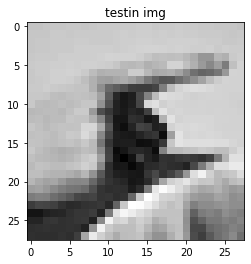


valeur de predictions :  6 


***********************************



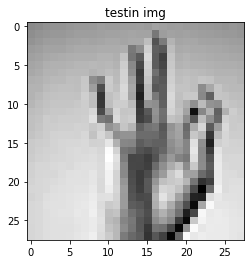


valeur de predictions :  5 


***********************************



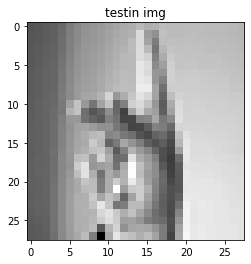


valeur de predictions :  10 


***********************************



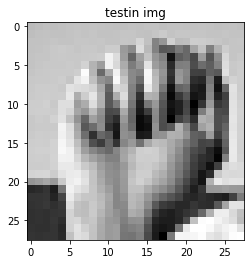


valeur de predictions :  0 


***********************************



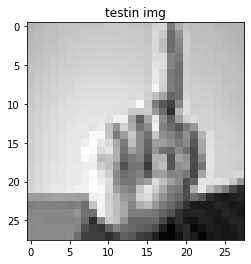


valeur de predictions :  3 


***********************************



In [21]:
for i in [0, 1, 2, 3, 4]:
  show_img(i,data_test)
  print("\nvaleur de predictions : ",predictions[i],"\n")
  print("\n***********************************\n")